In [26]:
import json
from collections import defaultdict

# Load the document_ids.json
with open('../data/processed_register/document_ids.json', 'r') as f:
    doc_ids = json.load(f)

from collections import defaultdict

# Build reverse lookup: hash → list of document paths
hash_to_docs = defaultdict(list)
for doc_path, info in doc_ids.items():
    doc_hash = info['hash']
    hash_to_docs[doc_hash].append(doc_path)

# Filter to only those with duplicates
duplicates = {h: paths for h, paths in hash_to_docs.items() if len(paths) > 1}

# Display duplicate sets
for h, paths in duplicates.items():
    print(f"\nHash: {h} ({len(paths)} duplicates)")
    for p in paths:
        print(" -", p)


Hash: 5ea6db115605afb062a170501447c7a9747ee5199cf9fc291b2bda754b3daff2 (2 duplicates)
 - cabinet/2025-01-30/originals/Printed minutes 30th-Jan-2025 10.00 Cabinet.pdf
 - cabinet/2025-03-04/originals/Minutes of Previous Meeting.pdf

Hash: f008f18088193b1ab96c9b36c532983e40af5fb957711f864b69a640f5bf3625 (2 duplicates)
 - cabinet/2025-01-30/originals/Appendix C - Potential Capital Projects.pdf
 - full_council/2025-02-13/originals/Appendix C - Potential Capital Projects.pdf

Hash: f6d75d41d059c23e1f6fa8d7acb3ed4c44ff89d22785f855c153181620abfd38 (2 duplicates)
 - cabinet/2025-03-04/originals/APPENDIX A - Planning Inspectors Report on the Examination of the KMWLP 2024-39.pdf
 - full_council/2025-03-13/originals/APPENDIX A - Planning Inspectors Report on the Examination of the KMWLP 2024-39.pdf

Hash: b06b6049f1af0ef77d22042fc9b2121f253a8bd6aff344855a5412426893a912 (2 duplicates)
 - cabinet/2025-03-04/originals/APPENDIX B - ADOPTION of KMWLP 2024-39.pdf
 - full_council/2025-03-13/originals/AP

In [10]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Locate metadata.json files in meeting folders
metadata_paths = list(Path("../data/council_documents").rglob("*/metadata.json"))
print(f"Found {len(metadata_paths)} metadata.json files")
metadata_paths[:5]

Found 35 metadata.json files


[PosixPath('../data/council_documents/cabinet/2024-11-28/metadata.json'),
 PosixPath('../data/council_documents/cabinet/2025-03-13/metadata.json'),
 PosixPath('../data/council_documents/cabinet/2024-01-04/metadata.json'),
 PosixPath('../data/council_documents/cabinet/2024-09-26/metadata.json'),
 PosixPath('../data/council_documents/cabinet/2024-01-25/metadata.json')]

In [28]:
import os
import json
import shutil
from pathlib import Path
from collections import defaultdict

# === CONFIGURATION ===
data_root = Path("../data/council_documents")
doc_id_path = data_root.parent / "processed_register/document_ids.json"
duplicates_folder = data_root / "duplicates"
duplicates_folder.mkdir(parents=True, exist_ok=True)

# === LOAD document_ids.json
with open(doc_id_path, "r") as f:
    doc_ids = json.load(f)

# === BUILD reverse lookup: hash → list of document paths
hash_to_paths = defaultdict(list)
for path, info in doc_ids.items():
    hash_to_paths[info["hash"]].append(path)

# === INIT
removed_files = []
doc_ids_to_delete = []

# === MAIN LOGIC
for doc_hash, paths in hash_to_paths.items():
    if len(paths) < 2:
        continue  # skip non-duplicates

    # Group by meeting folder
    meeting_groups = defaultdict(list)
    for p in paths:
        parts = Path(p).parts
        meeting_key = "/".join(parts[:2])  # e.g., full_council/2025-02-13
        meeting_groups[meeting_key].append(p)

    for meeting, path_list in meeting_groups.items():
        if len(path_list) < 2:
            continue

        # Look for pairs where one ends in "_1.pdf"
        for p in path_list:
            if p.endswith("_1.pdf"):
                try:
                    full_path = data_root / p
                    target_path = duplicates_folder / Path(p).name

                    # Move to duplicates folder
                    shutil.move(str(full_path), str(target_path))
                    removed_files.append(p)
                    doc_ids_to_delete.append(p)

                    # Update metadata.json (if present)
                    meta_path = data_root / meeting / "metadata.json"
                    if meta_path.exists():
                        with open(meta_path, "r", encoding="utf-8") as f:
                            metadata = json.load(f)
                        for entry in metadata:
                            if entry.get("filename") == Path(p).name:
                                entry["duplicate_removed"] = True
                        with open(meta_path, "w", encoding="utf-8") as f:
                            json.dump(metadata, f, indent=2, ensure_ascii=False)

                except Exception as e:
                    print(f"⚠️ Error processing {p}: {e}")

# === CLEAN document_ids.json
for p in doc_ids_to_delete:
    if p in doc_ids:
        del doc_ids[p]

with open(doc_id_path, "w") as f:
    json.dump(doc_ids, f, indent=2)

print(f"✅ Moved {len(removed_files)} duplicate files to /duplicates")
print(f"❌ Removed {len(doc_ids_to_delete)} entries from document_ids.json")

✅ Moved 6 duplicate files to /duplicates
❌ Removed 6 entries from document_ids.json


In [29]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Locate all metadata.json files under each meeting folder
metadata_paths = list(Path("../data/council_documents").rglob("*/metadata.json"))

# Collect records
records = []

for path in tqdm(metadata_paths):
    with open(path, "r") as f:
        try:
            data = json.load(f)
            committee, meeting_date = path.parts[-3], path.parts[-2]
            for item in data:
                item['committee'] = committee
                item['meeting_date'] = meeting_date
                records.append(item)
        except Exception as e:
            print(f"⚠️ Error loading {path}: {e}")

100%|██████████| 11/11 [00:00<00:00, 2150.22it/s]


In [30]:
df = pd.DataFrame(records)

# Convert meeting_date to datetime
df['meeting_date'] = pd.to_datetime(df['meeting_date'], errors='coerce')

# View column names and a sample
df.columns
df.head()

,filename,path,type,committee,meeting_date,document_category,url,created,duplicate_removed
0,Agenda frontsheet 13th-Mar-2025 15.00 Cabinet.pdf,originals/Agenda frontsheet 13th-Mar-2025 15.0...,pdf,cabinet,2025-03-13,agenda_frontsheet,https://democracy.kent.gov.uk/documents/g9767/...,2025-05-07T00:35:46.746119,NaN
1,Public reports pack 13th-Mar-2025 15.00 Cabine...,originals/Public reports pack 13th-Mar-2025 15...,pdf,cabinet,2025-03-13,report,https://democracy.kent.gov.uk/documents/g9767/...,2025-05-07T00:35:47.721603,NaN
2,Agenda frontsheet 30th-Jan-2025 10.00 Cabinet.pdf,originals/Agenda frontsheet 30th-Jan-2025 10.0...,pdf,cabinet,2025-01-30,agenda_frontsheet,https://democracy.kent.gov.uk/documents/g9475/...,2025-05-07T00:36:06.596864,NaN
3,24-00096 - PROD 30th-Jan-2025 10.00 Cabinet.pdf,originals/24-00096 - PROD 30th-Jan-2025 10.00 ...,pdf,cabinet,2025-01-30,other,https://democracy.kent.gov.uk/documents/b25205...,2025-05-07T00:36:07.664662,NaN
4,Item 7 - Supplementary - 2400109 - Transfer th...,originals/Item 7 - Supplementary - 2400109 - T...,pdf,cabinet,2025-01-30,other,https://democracy.kent.gov.uk/documents/b25207...,2025-05-07T00:36:08.777909,NaN


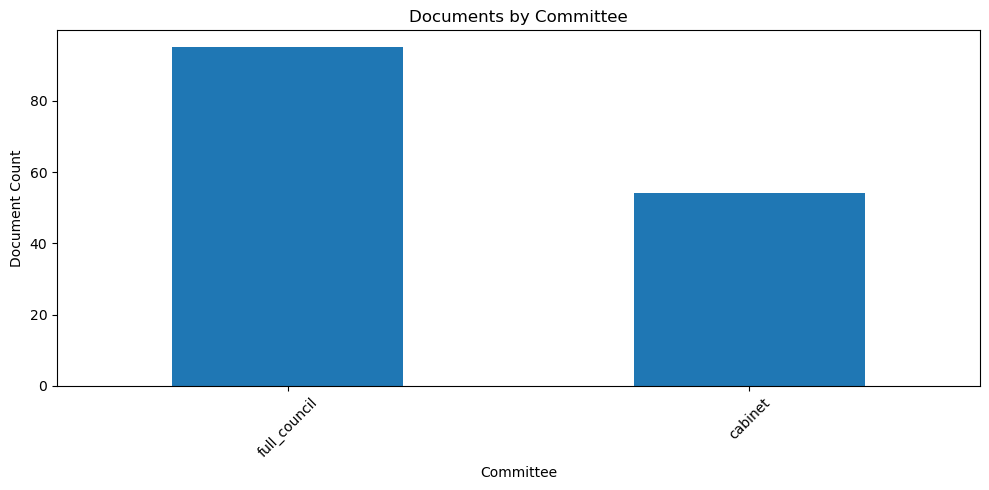

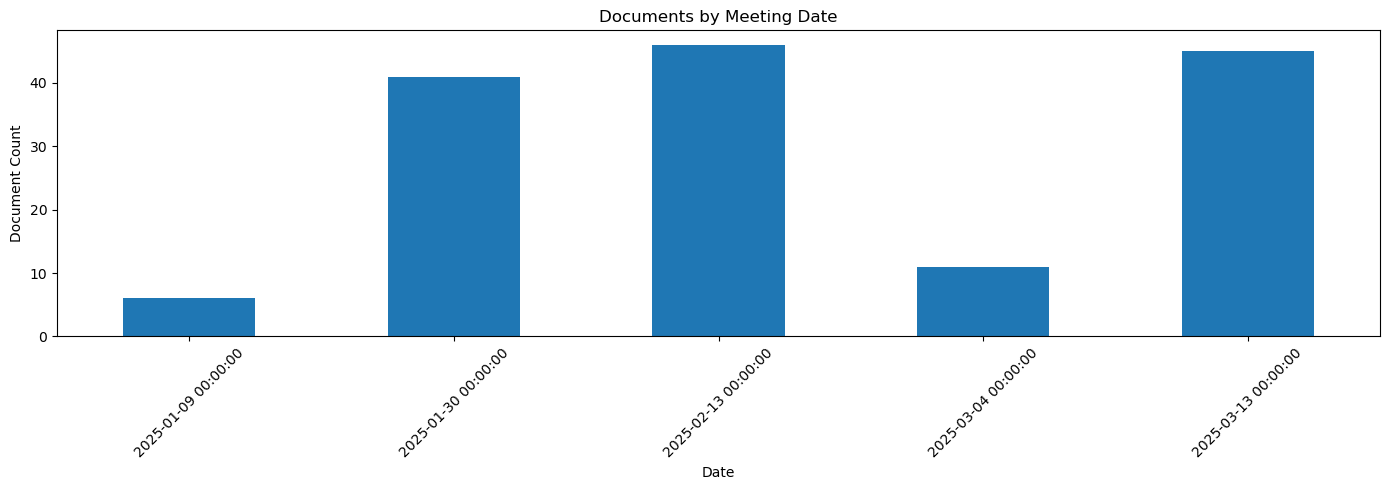

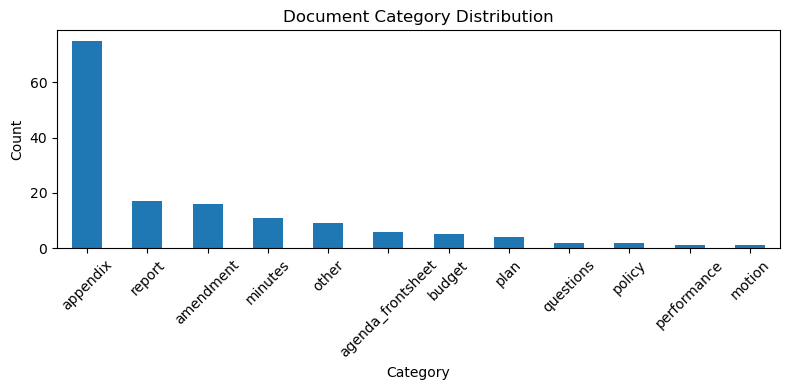

No 'file_size' column available.


In [31]:
import matplotlib.pyplot as plt
committee_counts = df['committee'].value_counts().sort_values(ascending=False)

committee_counts.plot(kind='bar', figsize=(10, 5))
plt.title("Documents by Committee")
plt.xlabel("Committee")
plt.ylabel("Document Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🗓️ Cell 3: Documents by Meeting Date (Chronological)

df['meeting_date'] = pd.to_datetime(df['meeting_date'], errors='coerce')
date_counts = df['meeting_date'].value_counts().sort_index()

date_counts.plot(kind='bar', figsize=(14, 5))
plt.title("Documents by Meeting Date")
plt.xlabel("Date")
plt.ylabel("Document Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🗂️ Cell 4: Documents by Document Category

if 'document_category' in df.columns:
    category_counts = df['document_category'].value_counts()

    category_counts.plot(kind='bar', figsize=(8, 4))
    plt.title("Document Category Distribution")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No 'document_category' column found.")

### 📦 Cell 5: File Size Distribution (if available)

if 'file_size' in df.columns:
    df['file_size_kb'] = df['file_size'] / 1024

    df['file_size_kb'].plot(kind='hist', bins=30, figsize=(8, 4), edgecolor='black')
    plt.title("Distribution of File Sizes (KB)")
    plt.xlabel("File Size (KB)")
    plt.ylabel("Document Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'file_size' column available.")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   filename           149 non-null    object        
 1   path               149 non-null    object        
 2   type               149 non-null    object        
 3   committee          149 non-null    object        
 4   meeting_date       149 non-null    datetime64[ns]
 5   document_category  149 non-null    object        
 6   url                149 non-null    object        
 7   created            149 non-null    object        
 8   duplicate_removed  6 non-null      object        
dtypes: datetime64[ns](1), object(8)
memory usage: 10.6+ KB


### Deleting all chunks (if needed)

In [34]:
from pathlib import Path
import shutil

base_dir = Path("../data/council_documents")
chunks_folders = list(base_dir.rglob("*/chunks"))

print(f"Found {len(chunks_folders)} chunks folders to delete...")

for folder in chunks_folders:
    try:
        shutil.rmtree(folder)
        print(f"✅ Deleted {folder}")
    except Exception as e:
        print(f"❌ Failed to delete {folder}: {e}")

print("🧼 All chunk folders removed.")

Found 0 chunks folders to delete...
🧼 All chunk folders removed.


### Deleting status from manifest - when chuncks have been manually removed using bash

In [36]:
import json
from pathlib import Path

manifest_path = Path("../data/processed_register/document_manifest.jsonl")
updated_lines = []

with open(manifest_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # skip empty lines
        try:
            entry = json.loads(line)
        except json.JSONDecodeError:
            print("⚠️ Skiipping malformed line:", line)
            continue

        chunk_path = entry.get("chunk_path")
        if chunk_path and not Path(chunk_path).exists():
            entry["status"] = "ready_for_chunking"
            entry["chunk_path"] = None

        updated_lines.append(json.dumps(entry, ensure_ascii=False))

with open(manifest_path, "w", encoding="utf-8") as f:
    for line in updated_lines:
        f.write(line + "\n")

print("✅ Manifest status reset for missing chunk files.")

✅ Manifest status reset for missing chunk files.
